# Evaluating Assembly, Polishing, and Sequencing results for PacBio and Illumina sequencing

### Maximillian Marin
### mgmarin@g.harvard.edu


### Import Statements

In [2]:
import numpy as np
import pandas as pd
import vcf
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.stats

%matplotlib inline

In [3]:
from Bio import SeqIO


### Set matplotlib text export settings for Adobe Illustrator

In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

#### Pandas Viewing Settings

In [5]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Parse Assembly and Sequence analysis results Sample Info

In [6]:
Repo_DataDir = "../../Data"

PMP_SM_ResultsSummary_Dir_210108 = Repo_DataDir + "/210108_PMP_SM_50CI_V7_ResultsSummary"


PMP_50CI_AssemblySummary_TSV_PATH = PMP_SM_ResultsSummary_Dir_210108 + "/210108_PMP_50CI_AssemblySummary_V7.tsv"

PMP_42CI_CicularOnly_AssemblySummary_TSV_PATH = PMP_SM_ResultsSummary_Dir_210108 + "/210108_PMP_42CI_CircularOnly_F2Filtered_AssemblySummary_V7.tsv" 

PMP_38CI_AtLeast40XMeanDepthIllumina_F2Filtered_AssemblySummary_TSV_PATH = PMP_SM_ResultsSummary_Dir_210108 + "/210108_PMP_38CI_AtLeast40XMeanDepthIllumina_F2Filtered_AssemblySummary_V7.tsv" 

PMP_36CI_CicularOnly_F2Filtered_AtLeast40XIllDepth_AssemblySummary_TSV_PATH = PMP_SM_ResultsSummary_Dir_210108 + "/210108_PMP_36CI_CircularOnly_F2Filtered_AtLeast40XMeanDepthIllumina_AssemblySummary_V7.tsv"       


PMP_50CI_AssemblySummary = pd.read_csv(PMP_50CI_AssemblySummary_TSV_PATH, sep = "\t")

PMP_42CI_CicularOnly_AssemblySummary = pd.read_csv(PMP_42CI_CicularOnly_AssemblySummary_TSV_PATH, sep = "\t")

PMP_38CI_F2Filtered_AtLeast40XDepth_AssemblySummary = pd.read_csv(PMP_38CI_AtLeast40XMeanDepthIllumina_F2Filtered_AssemblySummary_TSV_PATH, sep = "\t")

PMP_36CI_CicularOnly_F2Filtered_AtLeast40XDepth_AssemblySummary = pd.read_csv(PMP_36CI_CicularOnly_F2Filtered_AtLeast40XIllDepth_AssemblySummary_TSV_PATH, sep = "\t")





PMP_36CI_AnalysisSet_AssemblySummary = PMP_36CI_CicularOnly_F2Filtered_AtLeast40XDepth_AssemblySummary

PMP_36CI_AnalysisSet_AssemblySummary = PMP_36CI_AnalysisSet_AssemblySummary.sort_values("PrimaryLineage_PB")

SampleIDs_36CI_SOI = list( PMP_36CI_AnalysisSet_AssemblySummary["SampleID"].values )


print(','.join(SampleIDs_36CI_SOI) )

# Make sample to lineage mapping dict

ID_To_IlluminaAvrgCov_Dict = dict(PMP_50CI_AssemblySummary[['SampleID', 'IlluminaWGSToH37rv_AvrgCov']].values)                     
ID_To_Lineage_Dict = dict(PMP_50CI_AssemblySummary[['SampleID', 'PrimaryLineage_PB']].values)
ID_To_Dataset_Dict = dict(PMP_50CI_AssemblySummary[['SampleID', 'Dataset_Tag']].values)

N0072,N0153,N0155,M0003941_3,DNA075,DNA091,DNA028,N0145,N0054,N1274,N0004,DNA020,AZE_02_042,DNA019_Rose,DNA188,DNA120,DNA044,M0011368_9,02_R1179,M0014888_3,M0016395_7,M0010874_7,01_R1430,02_R0894,02_R1708,02_R1896,M0016737_0,M0017522_5,01_R1134,DNA086,N1272,N1176,N1177,N1202,N0091,RW-TB008


### Let's verify the shapes of the metadata dataframes

In [7]:
PMP_50CI_AssemblySummary.shape

(50, 26)

In [8]:
PMP_42CI_CicularOnly_AssemblySummary.shape

(42, 26)

In [9]:
PMP_36CI_AnalysisSet_AssemblySummary.shape

(36, 26)

# Define output directory of the data processing pipeline

In [10]:
# Define varaint calling pipeline output directories

PacBio_ProjectDir = "/n/data1/hms/dbmi/farhat/mm774/Projects/PacBio_Evaluation_Project"
PMP_SM_Outputs_Dir = PacBio_ProjectDir + "/PacmanPipe_SM_Outputs"
PMP_SM_TB_Portals_R1_Illumina_WGS_201201_OutputDir = PMP_SM_Outputs_Dir + "/201201_PMP_SM_TB_Portals_R1_Output_V2"

# Exploring the data processing results of our combined PacBio + Illumina WGS dataset

In [11]:
PMP_36CI_AnalysisSet_AssemblySummary.shape

(36, 26)

In [12]:
PMP_50CI_AssemblySummary["numContigs_Complete"].value_counts()

1    47
0     3
Name: numContigs_Complete, dtype: int64

In [11]:
PMP_36CI_AnalysisSet_AssemblySummary.head(50)

,SampleID,numContigs_Complete,circContig_Length,circContig_Cov,PacBio_Subread_Median_Length,LineageCall_Illumina,LineageCall_PacBio,F2_Illumina,F2_PacBio,ANI_I3,ANI_I3_PP,IlluminaWGSToH37rv_AvrgCov,PacBio_Subreads_H37Rv_AvrgCov,NumAnno_ORFs_PB_PilonPolished,NumAnno_ORFs_PB_DeNovo,GCcontent_PB_PP_GBK,NumChanges_PilonPolished,NumSNPs_PilonPolished,NumTotalInsertions_PilonPolished,Num1bpInsertion_PilonPolished,Num2bpInsertion_PilonPolished,NumTotalDeletions_PilonPolished,Num1bpDeletion_PilonPolished,PrimaryLineage_PB,PrimaryLineage_Ill,Dataset_Tag
14,N0072,1,4421406,358,2413.0,"lineage1,lineage1.1,lineage1.1.2","lineage1,lineage1.1,lineage1.1.2",0.021909,0.263559,99.8849,99.8852,112,348,4047,4051,65.610969,11,0,4,3,1,7,7,lineage1,lineage1,ChinerOms_2019
15,N0153,1,4389210,372,2027.0,"lineage1,lineage1.1,lineage1.1.1,lineage1.1.1.1","lineage1,lineage1.1,lineage1.1.1,lineage1.1.1.1",0.023551,0.272487,99.8687,99.8692,98,370,4037,4043,65.612081,53,19,2,1,1,32,32,lineage1,lineage1,ChinerOms_2019
17,N0155,1,4415285,335,2167.0,"lineage2,lineage2.2,lineage2.2.1","lineage2,lineage2.2,lineage2.2.1",0.005962,0.253724,99.8969,99.8974,61,326,4070,4076,65.611330,36,15,5,5,0,16,16,lineage2,lineage2,ChinerOms_2019
11,M0003941_3,1,4420723,206,5023.5,"lineage2,lineage2.2,lineage2.2.1","lineage2,lineage2.2,lineage2.2.1",0.011555,0.334658,99.8797,99.8952,273,189,4093,4268,65.609616,453,0,449,448,1,4,4,lineage2,lineage2,Farhat_Peru_2019
27,DNA075,1,4410963,753,7087.0,"lineage2,lineage2.2,lineage2.2.1","lineage2,lineage2.2,lineage2.2.1",0.009901,0.270275,99.8885,99.8895,46,715,4067,4087,65.614151,54,3,5,5,0,46,46,lineage2,lineage2,TB_Portals_15CI_R1
28,DNA091,1,4409629,807,7041.0,"lineage2,lineage2.2,lineage2.2.1","lineage2,lineage2.2,lineage2.2.1",0.008816,0.269834,99.8936,99.8934,74,779,4059,4081,65.608685,48,0,4,3,1,44,44,lineage2,lineage2,TB_Portals_15CI_R1
26,DNA028,1,4418534,437,5819.0,"lineage2,lineage2.2,lineage2.2.1","lineage2,lineage2.2,lineage2.2.1",0.012282,0.252604,99.8934,99.8946,48,419,4076,4093,65.608486,50,3,5,5,0,42,42,lineage2,lineage2,TB_Portals_15CI_R1
16,N0145,1,4416863,344,2042.0,"lineage2,lineage2.2,lineage2.2.1,lineage2.2.1.1","lineage2,lineage2.2,lineage2.2.1,lineage2.2.1.1",0.008973,0.262688,99.8914,99.8941,89,344,4071,4073,65.604423,20,0,2,2,0,18,18,lineage2,lineage2,ChinerOms_2019
20,N0054,1,4433942,225,2798.0,lineage3,lineage3,0.010867,0.243561,99.9051,99.9051,80,220,4095,4097,65.610456,8,0,0,0,0,8,7,lineage3,lineage3,ChinerOms_2019
19,N1274,1,4439099,366,2058.0,lineage3,lineage3,0.014975,0.254314,99.9041,99.9035,92,359,4092,4100,65.621746,17,2,1,0,0,14,13,lineage3,lineage3,ChinerOms_2019


In [12]:
PMP_36CI_AnalysisSet_AssemblySummary["NumChanges_PilonPolished"].sum()

5053

## Depth statistics for PacBio and Illumina WGS data (36 selected isolates w/ complete genome assemblies)

This dataset of clinical Mtb isolates with paired Illumina and PacBio sequencing has a median PacBio depth of 211X (IQR: 158X - 306X) and a median Illumina coverage of 89X (IQR: 57X - 111X) relative to the H37rv reference genome.

In [13]:
PMP_38CI_F2Filtered_AtLeast40XDepth_AssemblySummary

,SampleID,numContigs_Complete,circContig_Length,circContig_Cov,PacBio_Subread_Median_Length,LineageCall_Illumina,LineageCall_PacBio,F2_Illumina,F2_PacBio,ANI_I3,ANI_I3_PP,IlluminaWGSToH37rv_AvrgCov,PacBio_Subreads_H37Rv_AvrgCov,NumAnno_ORFs_PB_PilonPolished,NumAnno_ORFs_PB_DeNovo,GCcontent_PB_PP_GBK,NumChanges_PilonPolished,NumSNPs_PilonPolished,NumTotalInsertions_PilonPolished,Num1bpInsertion_PilonPolished,Num2bpInsertion_PilonPolished,NumTotalDeletions_PilonPolished,Num1bpDeletion_PilonPolished,PrimaryLineage_PB,PrimaryLineage_Ill,Dataset_Tag
0,M0011368_9,1,4397765,203,3773.0,"lineage4,lineage4.4,lineage4.4.1","lineage4,lineage4.4,lineage4.4.1",0.004937,0.305222,99.9368,99.9364,40,191,4050,4075,65.614721,63,0,59,58,1,4,4,lineage4,lineage4,Farhat_Peru_2019
1,M0014888_3,1,4399966,194,5038.0,"lineage4,lineage4.1,lineage4.1.2,lineage4.1.2.1","lineage4,lineage4.1,lineage4.1.2,lineage4.1.2.1",0.007132,0.279607,99.9185,99.9193,77,182,4048,4060,65.635971,39,0,39,39,0,0,0,lineage4,lineage4,Farhat_Peru_2019
2,M0016395_7,1,4420916,195,4621.0,"lineage4,lineage4.3,lineage4.3.2","lineage4,lineage4.3,lineage4.3.2",0.003671,0.299199,99.9248,99.9262,43,183,4068,4096,65.615829,71,1,66,65,1,4,4,lineage4,lineage4,Farhat_Peru_2019
3,M0010874_7,1,4396274,172,4675.0,"lineage4,lineage4.3,lineage4.3.3","lineage4,lineage4.3,lineage4.3.3",0.002880,0.289791,99.9283,99.9310,89,161,4054,4103,65.614744,111,9,95,95,0,7,6,lineage4,lineage4,Farhat_Peru_2019
4,01_R1430,1,4409128,227,6009.0,"lineage4,lineage4.4,lineage4.4.1","lineage4,lineage4.4,lineage4.4.1",0.005372,0.295069,99.9284,99.9290,253,212,4070,4119,65.613390,93,0,90,89,0,3,3,lineage4,lineage4,Farhat_Peru_2019
5,02_R0848,0,0,0,4908.0,"lineage4,lineage4.4,lineage4.4.1,lineage4.4.1.1","lineage4,lineage4.4,lineage4.4.1,lineage4.4.1.1",0.009652,0.318674,99.9197,99.9290,175,156,4078,4246,65.634370,356,0,356,355,1,0,0,lineage4,lineage4,Farhat_Peru_2019
6,02_R0894,1,4422314,191,4836.0,"lineage4,lineage4.1,lineage4.1.2,lineage4.1.2.1","lineage4,lineage4.1,lineage4.1.2,lineage4.1.2.1",0.013648,0.304220,99.9224,99.9284,141,178,4076,4180,65.635659,190,0,189,188,1,1,1,lineage4,lineage4,Farhat_Peru_2019
7,02_R1708,1,4426275,193,5907.0,"lineage4,lineage4.1,lineage4.1.2,lineage4.1.2.1","lineage4,lineage4.1,lineage4.1.2,lineage4.1.2.1",0.006856,0.328144,99.9152,99.9136,163,177,4078,4384,65.629736,735,0,731,730,0,4,4,lineage4,lineage4,Farhat_Peru_2019
8,02_R1896,1,4406804,195,5385.0,"lineage4,lineage4.4,lineage4.4.1,lineage4.4.1.1","lineage4,lineage4.4,lineage4.4.1,lineage4.4.1.1",0.005804,0.321782,99.9156,99.9216,117,179,4068,4295,65.609996,501,0,499,496,3,2,2,lineage4,lineage4,Farhat_Peru_2019
9,M0016737_0,1,4431421,162,5691.0,"lineage4,lineage4.5","lineage4,lineage4.5",0.005269,0.307715,99.9452,99.9460,96,151,4096,4142,65.619514,92,0,88,86,1,4,4,lineage4,lineage4,Farhat_Peru_2019


### PacBio WGS Depth

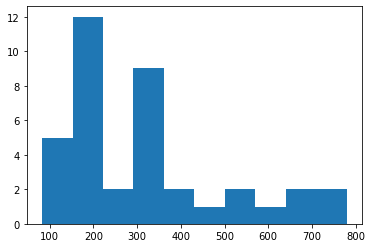

count     38.000000
mean     320.500000
std      181.764884
min       83.000000
25%      179.750000
50%      285.500000
75%      367.250000
max      779.000000
Name: PacBio_Subreads_H37Rv_AvrgCov, dtype: float64

In [14]:
plt.hist(PMP_38CI_F2Filtered_AtLeast40XDepth_AssemblySummary["PacBio_Subreads_H37Rv_AvrgCov"])

plt.show()
PMP_38CI_F2Filtered_AtLeast40XDepth_AssemblySummary["PacBio_Subreads_H37Rv_AvrgCov"].describe()

### Illumina WGS Coverage

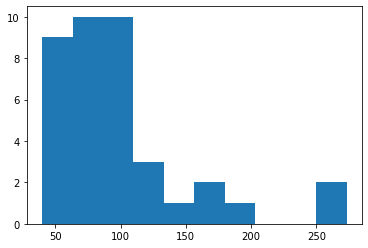

count     38.000000
mean      97.131579
std       52.823096
min       40.000000
25%       66.500000
50%       83.500000
75%      107.250000
max      273.000000
Name: IlluminaWGSToH37rv_AvrgCov, dtype: float64

In [15]:
plt.hist(PMP_38CI_F2Filtered_AtLeast40XDepth_AssemblySummary["IlluminaWGSToH37rv_AvrgCov"])

plt.show()
PMP_38CI_F2Filtered_AtLeast40XDepth_AssemblySummary["IlluminaWGSToH37rv_AvrgCov"].describe()

## General Genome stats across 36 assemblies

Genome Size range: 4.38 - 4.44 Mb, <br>
GC content range: 65.59 - 65.64 %, <br>
Number of predicted protein-coding genes (4017 - 4096). <br>



## What is the distribution of genome size across the final assemblies?

Genome Size range: 4.38 - 4.44 Mb, <br>

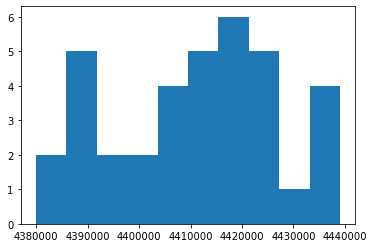

count    3.600000e+01
mean     4.411260e+06
std      1.609890e+04
min      4.379895e+06
25%      4.397392e+06
50%      4.413103e+06
75%      4.421633e+06
max      4.439099e+06
Name: circContig_Length, dtype: float64

In [16]:
plt.hist(PMP_36CI_AnalysisSet_AssemblySummary["circContig_Length"])

plt.show()
PMP_36CI_AnalysisSet_AssemblySummary["circContig_Length"].describe()

In [17]:
PMP_36CI_AnalysisSet_AssemblySummary["circContig_Length"].describe()["min"]

4379895.0

In [18]:
PMP_36CI_AnalysisSet_AssemblySummary["circContig_Length"].describe()["max"]

4439099.0

In [19]:
PMP_36CI_AnalysisSet_AssemblySummary.head(1)

,SampleID,numContigs_Complete,circContig_Length,circContig_Cov,PacBio_Subread_Median_Length,LineageCall_Illumina,LineageCall_PacBio,F2_Illumina,F2_PacBio,ANI_I3,ANI_I3_PP,IlluminaWGSToH37rv_AvrgCov,PacBio_Subreads_H37Rv_AvrgCov,NumAnno_ORFs_PB_PilonPolished,NumAnno_ORFs_PB_DeNovo,GCcontent_PB_PP_GBK,NumChanges_PilonPolished,NumSNPs_PilonPolished,NumTotalInsertions_PilonPolished,Num1bpInsertion_PilonPolished,Num2bpInsertion_PilonPolished,NumTotalDeletions_PilonPolished,Num1bpDeletion_PilonPolished,PrimaryLineage_PB,PrimaryLineage_Ill,Dataset_Tag
14,N0072,1,4421406,358,2413.0,"lineage1,lineage1.1,lineage1.1.2","lineage1,lineage1.1,lineage1.1.2",0.021909,0.263559,99.8849,99.8852,112,348,4047,4051,65.610969,11,0,4,3,1,7,7,lineage1,lineage1,ChinerOms_2019


## What is the distribution of GC content across the final assemblies?

GC content range: 65.59 - 65.64 

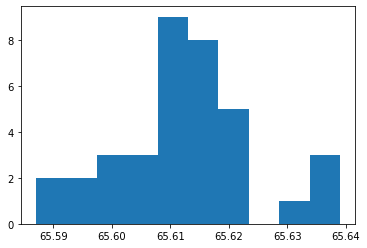

In [20]:
plt.hist(PMP_36CI_AnalysisSet_AssemblySummary["GCcontent_PB_PP_GBK"])

plt.show()

In [21]:
PMP_36CI_AnalysisSet_AssemblySummary["GCcontent_PB_PP_GBK"].describe()

count    36.000000
mean     65.611962
std       0.012131
min      65.586976
25%      65.604802
50%      65.611706
75%      65.616908
max      65.639001
Name: GCcontent_PB_PP_GBK, dtype: float64

## What is the distribution of predicted ORFs across the final assemblies?
(4017 - 4096 ORFs)

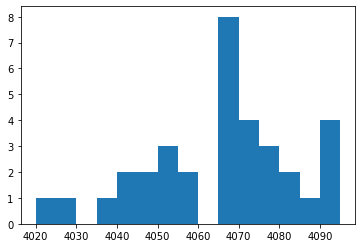

count      36.000000
mean     4064.388889
std        20.190914
min      4017.000000
25%      4051.500000
50%      4068.000000
75%      4076.500000
max      4096.000000
Name: NumAnno_ORFs_PB_PilonPolished, dtype: float64

In [22]:
plt.hist(PMP_36CI_AnalysisSet_AssemblySummary["NumAnno_ORFs_PB_PilonPolished"], bins = np.arange(4020, 4100, 5))

plt.show()
PMP_36CI_AnalysisSet_AssemblySummary["NumAnno_ORFs_PB_PilonPolished"].describe()

# Read Length Analysis

## What is the distribution of median read length values across the 36 sequencing runs evaluated?

In [23]:
PMP_36CI_AnalysisSet_AssemblySummary.head()

,SampleID,numContigs_Complete,circContig_Length,circContig_Cov,PacBio_Subread_Median_Length,LineageCall_Illumina,LineageCall_PacBio,F2_Illumina,F2_PacBio,ANI_I3,ANI_I3_PP,IlluminaWGSToH37rv_AvrgCov,PacBio_Subreads_H37Rv_AvrgCov,NumAnno_ORFs_PB_PilonPolished,NumAnno_ORFs_PB_DeNovo,GCcontent_PB_PP_GBK,NumChanges_PilonPolished,NumSNPs_PilonPolished,NumTotalInsertions_PilonPolished,Num1bpInsertion_PilonPolished,Num2bpInsertion_PilonPolished,NumTotalDeletions_PilonPolished,Num1bpDeletion_PilonPolished,PrimaryLineage_PB,PrimaryLineage_Ill,Dataset_Tag
14,N0072,1,4421406,358,2413.0,"lineage1,lineage1.1,lineage1.1.2","lineage1,lineage1.1,lineage1.1.2",0.021909,0.263559,99.8849,99.8852,112,348,4047,4051,65.610969,11,0,4,3,1,7,7,lineage1,lineage1,ChinerOms_2019
15,N0153,1,4389210,372,2027.0,"lineage1,lineage1.1,lineage1.1.1,lineage1.1.1.1","lineage1,lineage1.1,lineage1.1.1,lineage1.1.1.1",0.023551,0.272487,99.8687,99.8692,98,370,4037,4043,65.612081,53,19,2,1,1,32,32,lineage1,lineage1,ChinerOms_2019
17,N0155,1,4415285,335,2167.0,"lineage2,lineage2.2,lineage2.2.1","lineage2,lineage2.2,lineage2.2.1",0.005962,0.253724,99.8969,99.8974,61,326,4070,4076,65.611330,36,15,5,5,0,16,16,lineage2,lineage2,ChinerOms_2019
11,M0003941_3,1,4420723,206,5023.5,"lineage2,lineage2.2,lineage2.2.1","lineage2,lineage2.2,lineage2.2.1",0.011555,0.334658,99.8797,99.8952,273,189,4093,4268,65.609616,453,0,449,448,1,4,4,lineage2,lineage2,Farhat_Peru_2019
27,DNA075,1,4410963,753,7087.0,"lineage2,lineage2.2,lineage2.2.1","lineage2,lineage2.2,lineage2.2.1",0.009901,0.270275,99.8885,99.8895,46,715,4067,4087,65.614151,54,3,5,5,0,46,46,lineage2,lineage2,TB_Portals_15CI_R1


In [24]:
PMP_36CI_AnalysisSet_AssemblySummary["Dataset_Tag"].value_counts()

Farhat_Peru_2019        13
ChinerOms_2019          12
TB_Portals_15CI_R1      10
Ngabonziza_Lin8_2020     1
Name: Dataset_Tag, dtype: int64

In [25]:
PMP_36CI_AnalysisSet_AssemblySummary["PacBio_Subread_Median_Length"].describe()

count      36.000000
mean     4519.444444
std      1799.517319
min      1753.000000
25%      2659.500000
50%      4805.500000
75%      5932.500000
max      7165.000000
Name: PacBio_Subread_Median_Length, dtype: float64

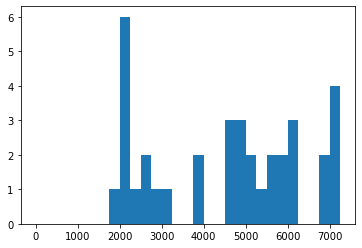

count      36.000000
mean     4519.444444
std      1799.517319
min      1753.000000
25%      2659.500000
50%      4805.500000
75%      5932.500000
max      7165.000000
Name: PacBio_Subread_Median_Length, dtype: float64

In [26]:
plt.hist(PMP_36CI_AnalysisSet_AssemblySummary["PacBio_Subread_Median_Length"], bins = np.arange(0, 7500, 250))

plt.show()
PMP_36CI_AnalysisSet_AssemblySummary["PacBio_Subread_Median_Length"].describe()

## What is the distribution of the number SNSs corrected during Illumina polishing?

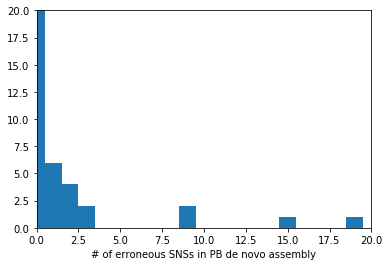

count    36.000000
mean      2.000000
std       4.289522
min       0.000000
25%       0.000000
50%       0.000000
75%       2.000000
max      19.000000
Name: NumSNPs_PilonPolished, dtype: float64

In [27]:
plt.hist(PMP_36CI_AnalysisSet_AssemblySummary["NumSNPs_PilonPolished"], bins = np.arange(-0.5, 50.5, 1))   

plt.xlabel("# of erroneous SNSs in PB de novo assembly")

plt.ylim(0,20)
plt.xlim(0,20)

plt.show()
PMP_36CI_AnalysisSet_AssemblySummary["NumSNPs_PilonPolished"].describe()

In [28]:
PMP_36CI_AnalysisSet_AssemblySummary["NumSNPs_PilonPolished"].value_counts()

0     20
1      6
2      4
9      2
3      2
19     1
15     1
Name: NumSNPs_PilonPolished, dtype: int64

## What is the distribution of the number Deletions corrected during Illumina polishing? 
(This means erroneous insertion)

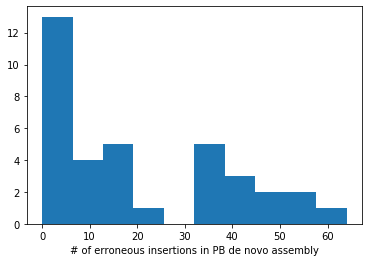

count    36.000000
mean     20.527778
std      19.304309
min       0.000000
25%       4.000000
50%      14.500000
75%      37.000000
max      64.000000
Name: NumTotalDeletions_PilonPolished, dtype: float64

In [29]:
plt.hist(PMP_36CI_AnalysisSet_AssemblySummary["NumTotalDeletions_PilonPolished"])

plt.xlabel("# of erroneous insertions in PB de novo assembly")

plt.show()

PMP_36CI_AnalysisSet_AssemblySummary["NumTotalDeletions_PilonPolished"].describe()

## What is the distribution of the number Insertions corrected during Illumina polishing? (This means erroneous deletions)

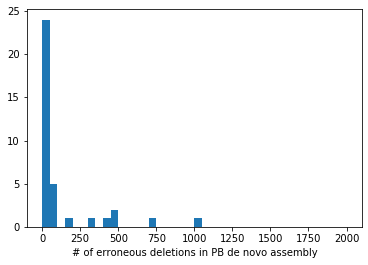

count      36.000000
mean      117.833333
std       236.839488
min         0.000000
25%         2.000000
50%         5.000000
75%        88.500000
max      1031.000000
Name: NumTotalInsertions_PilonPolished, dtype: float64

In [30]:

plt.hist(PMP_36CI_AnalysisSet_AssemblySummary["NumTotalInsertions_PilonPolished"],
         bins = np.arange(0, 2000 + 50, 50))
plt.xlabel("# of erroneous deletions in PB de novo assembly")

plt.show()
PMP_36CI_AnalysisSet_AssemblySummary["NumTotalInsertions_PilonPolished"].describe()


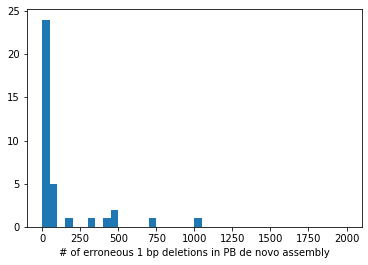

count      36.000000
mean      116.833333
std       235.643496
min         0.000000
25%         1.000000
50%         5.000000
75%        86.750000
max      1022.000000
Name: Num1bpInsertion_PilonPolished, dtype: float64

In [31]:
plt.hist(PMP_36CI_AnalysisSet_AssemblySummary["Num1bpInsertion_PilonPolished"], bins = np.arange(0, 2000 + 50, 50))

plt.xlabel("# of erroneous 1 bp deletions in PB de novo assembly")


plt.show()
PMP_36CI_AnalysisSet_AssemblySummary["Num1bpInsertion_PilonPolished"].describe()

In [32]:
PMP_36CI_AnalysisSet_AssemblySummary.head(2)

,SampleID,numContigs_Complete,circContig_Length,circContig_Cov,PacBio_Subread_Median_Length,LineageCall_Illumina,LineageCall_PacBio,F2_Illumina,F2_PacBio,ANI_I3,ANI_I3_PP,IlluminaWGSToH37rv_AvrgCov,PacBio_Subreads_H37Rv_AvrgCov,NumAnno_ORFs_PB_PilonPolished,NumAnno_ORFs_PB_DeNovo,GCcontent_PB_PP_GBK,NumChanges_PilonPolished,NumSNPs_PilonPolished,NumTotalInsertions_PilonPolished,Num1bpInsertion_PilonPolished,Num2bpInsertion_PilonPolished,NumTotalDeletions_PilonPolished,Num1bpDeletion_PilonPolished,PrimaryLineage_PB,PrimaryLineage_Ill,Dataset_Tag
14,N0072,1,4421406,358,2413.0,"lineage1,lineage1.1,lineage1.1.2","lineage1,lineage1.1,lineage1.1.2",0.021909,0.263559,99.8849,99.8852,112,348,4047,4051,65.610969,11,0,4,3,1,7,7,lineage1,lineage1,ChinerOms_2019
15,N0153,1,4389210,372,2027.0,"lineage1,lineage1.1,lineage1.1.1,lineage1.1.1.1","lineage1,lineage1.1,lineage1.1.1,lineage1.1.1.1",0.023551,0.272487,99.8687,99.8692,98,370,4037,4043,65.612081,53,19,2,1,1,32,32,lineage1,lineage1,ChinerOms_2019


In [33]:
PMP_36CI_AnalysisSet_AssemblySummary["circContig_Length"].describe()

count    3.600000e+01
mean     4.411260e+06
std      1.609890e+04
min      4.379895e+06
25%      4.397392e+06
50%      4.413103e+06
75%      4.421633e+06
max      4.439099e+06
Name: circContig_Length, dtype: float64

In [34]:
PMP_36CI_AnalysisSet_AssemblySummary.head(1)

,SampleID,numContigs_Complete,circContig_Length,circContig_Cov,PacBio_Subread_Median_Length,LineageCall_Illumina,LineageCall_PacBio,F2_Illumina,F2_PacBio,ANI_I3,ANI_I3_PP,IlluminaWGSToH37rv_AvrgCov,PacBio_Subreads_H37Rv_AvrgCov,NumAnno_ORFs_PB_PilonPolished,NumAnno_ORFs_PB_DeNovo,GCcontent_PB_PP_GBK,NumChanges_PilonPolished,NumSNPs_PilonPolished,NumTotalInsertions_PilonPolished,Num1bpInsertion_PilonPolished,Num2bpInsertion_PilonPolished,NumTotalDeletions_PilonPolished,Num1bpDeletion_PilonPolished,PrimaryLineage_PB,PrimaryLineage_Ill,Dataset_Tag
14,N0072,1,4421406,358,2413.0,"lineage1,lineage1.1,lineage1.1.2","lineage1,lineage1.1,lineage1.1.2",0.021909,0.263559,99.8849,99.8852,112,348,4047,4051,65.610969,11,0,4,3,1,7,7,lineage1,lineage1,ChinerOms_2019


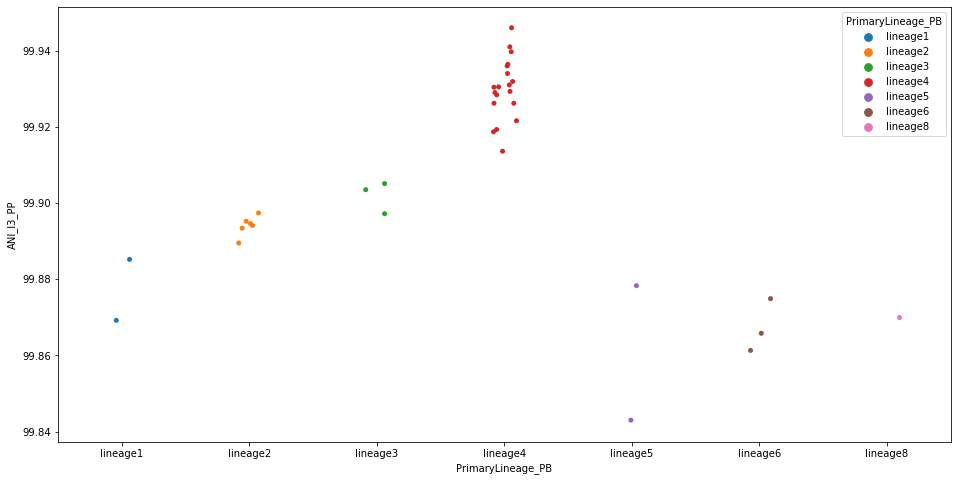

In [35]:
plt.figure( figsize = (16,8))
sns.stripplot(x = "PrimaryLineage_PB",
               y = "ANI_I3_PP",
               hue = "PrimaryLineage_PB",
               data = PMP_36CI_AnalysisSet_AssemblySummary)

plt.show()

## What is the distribution of the number ANIs to H37rv across all 36 isolates?
Range: 99.84% to 99.95% ANI to H37rv reference

In [36]:
PMP_36CI_AnalysisSet_AssemblySummary["ANI_I3_PP"].describe()

count    36.000000
mean     99.907975
std       0.026893
min      99.843000
25%      99.892425
50%      99.916150
75%      99.930425
max      99.946000
Name: ANI_I3_PP, dtype: float64

In [37]:
from scipy import stats

In [38]:
stats.spearmanr( PMP_36CI_AnalysisSet_AssemblySummary["circContig_Cov"], PMP_36CI_AnalysisSet_AssemblySummary["NumChanges_PilonPolished"] )    

SpearmanrResult(correlation=-0.4580624481935152, pvalue=0.004964559863879903)

In [39]:
PMP_36CI_AnalysisSet_AssemblySummary.head(4)

,SampleID,numContigs_Complete,circContig_Length,circContig_Cov,PacBio_Subread_Median_Length,LineageCall_Illumina,LineageCall_PacBio,F2_Illumina,F2_PacBio,ANI_I3,ANI_I3_PP,IlluminaWGSToH37rv_AvrgCov,PacBio_Subreads_H37Rv_AvrgCov,NumAnno_ORFs_PB_PilonPolished,NumAnno_ORFs_PB_DeNovo,GCcontent_PB_PP_GBK,NumChanges_PilonPolished,NumSNPs_PilonPolished,NumTotalInsertions_PilonPolished,Num1bpInsertion_PilonPolished,Num2bpInsertion_PilonPolished,NumTotalDeletions_PilonPolished,Num1bpDeletion_PilonPolished,PrimaryLineage_PB,PrimaryLineage_Ill,Dataset_Tag
14,N0072,1,4421406,358,2413.0,"lineage1,lineage1.1,lineage1.1.2","lineage1,lineage1.1,lineage1.1.2",0.021909,0.263559,99.8849,99.8852,112,348,4047,4051,65.610969,11,0,4,3,1,7,7,lineage1,lineage1,ChinerOms_2019
15,N0153,1,4389210,372,2027.0,"lineage1,lineage1.1,lineage1.1.1,lineage1.1.1.1","lineage1,lineage1.1,lineage1.1.1,lineage1.1.1.1",0.023551,0.272487,99.8687,99.8692,98,370,4037,4043,65.612081,53,19,2,1,1,32,32,lineage1,lineage1,ChinerOms_2019
17,N0155,1,4415285,335,2167.0,"lineage2,lineage2.2,lineage2.2.1","lineage2,lineage2.2,lineage2.2.1",0.005962,0.253724,99.8969,99.8974,61,326,4070,4076,65.611330,36,15,5,5,0,16,16,lineage2,lineage2,ChinerOms_2019
11,M0003941_3,1,4420723,206,5023.5,"lineage2,lineage2.2,lineage2.2.1","lineage2,lineage2.2,lineage2.2.1",0.011555,0.334658,99.8797,99.8952,273,189,4093,4268,65.609616,453,0,449,448,1,4,4,lineage2,lineage2,Farhat_Peru_2019


In [40]:
PMP_36CI_AnalysisSet_AssemblySummary["NumINDELs_All_PilonPolished"] = PMP_36CI_AnalysisSet_AssemblySummary["NumTotalInsertions_PilonPolished"]  + PMP_36CI_AnalysisSet_AssemblySummary["NumTotalDeletions_PilonPolished"]               

In [44]:
stats.spearmanr( PMP_36CI_AnalysisSet_AssemblySummary["circContig_Cov"], PMP_36CI_AnalysisSet_AssemblySummary["NumChanges_PilonPolished"] )    


SpearmanrResult(correlation=-0.4580624481935152, pvalue=0.004964559863879903)

mkdir: cannot create directory ‘./PilonPolishing_CorrectionsPlots/’: File exists


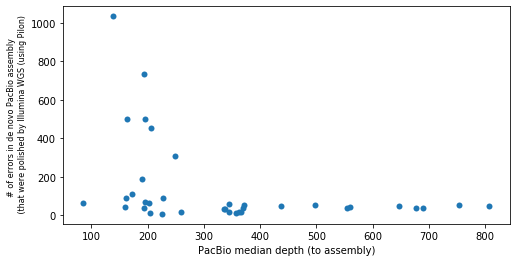

In [45]:
plt.figure( figsize = (8,4))
sns.scatterplot(x="circContig_Cov", y="NumChanges_PilonPolished",
                # hue = "numContigs_Complete", #style = "Dataset_Tag",
                data = PMP_36CI_AnalysisSet_AssemblySummary, linewidth=0,)

plt.xlabel("PacBio median depth (to assembly)")
plt.ylabel("# of errors in de novo PacBio assembly \n (that were polished by Illumina WGS (using Pilon)", fontsize=8)

!mkdir ./PilonPolishing_CorrectionsPlots/
Output_PNG_PATH = "./PilonPolishing_CorrectionsPlots/SupFig2_PMP_36CI_PacBioMedianDepth_Vs_NumberOfPilonCorrections.png"
Output_PDF_PATH = "./PilonPolishing_CorrectionsPlots/SupFig2_PMP_36CI_PacBioMedianDepth_Vs_NumberOfPilonCorrections.pdf"
plt.savefig(Output_PNG_PATH, bbox_inches='tight', dpi=125)
plt.savefig(Output_PDF_PATH, bbox_inches='tight', transparent=True)

plt.show()

mkdir: cannot create directory ‘./PilonPolishing_CorrectionsPlots/’: File exists


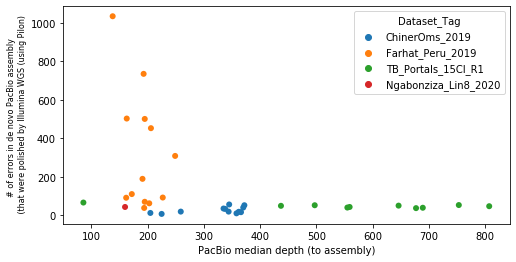

In [46]:
plt.figure( figsize = (8,4))
sns.scatterplot(x="circContig_Cov", y="NumChanges_PilonPolished",
                hue = "Dataset_Tag", #style = "Dataset_Tag",
                data = PMP_36CI_AnalysisSet_AssemblySummary, linewidth=0,)

plt.xlabel("PacBio median depth (to assembly)")
plt.ylabel("# of errors in de novo PacBio assembly \n (that were polished by Illumina WGS (using Pilon)", fontsize=8)

!mkdir ./PilonPolishing_CorrectionsPlots/
#Output_PNG_PATH = "./PilonPolishing_CorrectionsPlots/PMP_36CI_PacBioMedianDepth_Vs_NumberOfPilonCorrections.png"
#Output_PDF_PATH = "./PilonPolishing_CorrectionsPlots/PMP_36CI_PacBioMedianDepth_Vs_NumberOfPilonCorrections.pdf"
#plt.savefig(Output_PNG_PATH, bbox_inches='tight', dpi=125)
#plt.savefig(Output_PDF_PATH, bbox_inches='tight', transparent=True)

plt.show()

In [47]:
PMP_36CI_AnalysisSet_AssemblySummary.head(1)

,SampleID,numContigs_Complete,circContig_Length,circContig_Cov,PacBio_Subread_Median_Length,LineageCall_Illumina,LineageCall_PacBio,F2_Illumina,F2_PacBio,ANI_I3,ANI_I3_PP,IlluminaWGSToH37rv_AvrgCov,PacBio_Subreads_H37Rv_AvrgCov,NumAnno_ORFs_PB_PilonPolished,NumAnno_ORFs_PB_DeNovo,GCcontent_PB_PP_GBK,NumChanges_PilonPolished,NumSNPs_PilonPolished,NumTotalInsertions_PilonPolished,Num1bpInsertion_PilonPolished,Num2bpInsertion_PilonPolished,NumTotalDeletions_PilonPolished,Num1bpDeletion_PilonPolished,PrimaryLineage_PB,PrimaryLineage_Ill,Dataset_Tag,NumINDELs_All_PilonPolished,NumINDELs_1bp_PilonPolished
14,N0072,1,4421406,358,2413.0,"lineage1,lineage1.1,lineage1.1.2","lineage1,lineage1.1,lineage1.1.2",0.021909,0.263559,99.8849,99.8852,112,348,4047,4051,65.610969,11,0,4,3,1,7,7,lineage1,lineage1,ChinerOms_2019,11,10


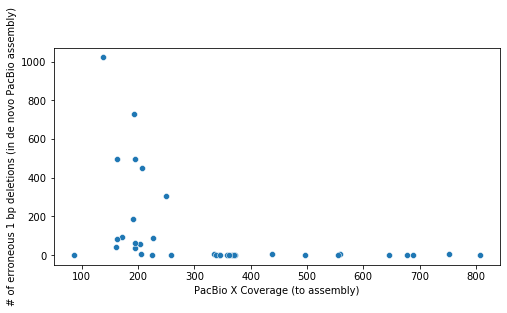

In [48]:
plt.figure( figsize = (8,4))
sns.scatterplot(x="circContig_Cov", y="Num1bpInsertion_PilonPolished",
                # hue = "numContigs_Complete", #style = "Dataset_Tag",
                data = PMP_36CI_AnalysisSet_AssemblySummary)

plt.xlabel("PacBio X Coverage (to assembly)")
plt.ylabel("# of erroneous 1 bp deletions (in de novo PacBio assembly)")


plt.show()

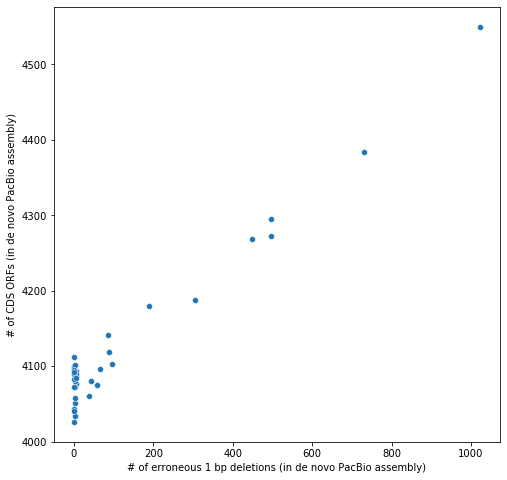

In [49]:
plt.figure( figsize = (8,8))
sns.scatterplot(x="Num1bpInsertion_PilonPolished", y="NumAnno_ORFs_PB_DeNovo",
                # hue = "numContigs_Complete", #style = "Dataset_Tag",
                data=PMP_36CI_AnalysisSet_AssemblySummary)

plt.xlabel("# of erroneous 1 bp deletions (in de novo PacBio assembly)")
plt.ylabel("# of CDS ORFs (in de novo PacBio assembly)")

plt.show()

In [50]:
PMP_36CI_AnalysisSet_AssemblySummary.head(1)

,SampleID,numContigs_Complete,circContig_Length,circContig_Cov,PacBio_Subread_Median_Length,LineageCall_Illumina,LineageCall_PacBio,F2_Illumina,F2_PacBio,ANI_I3,ANI_I3_PP,IlluminaWGSToH37rv_AvrgCov,PacBio_Subreads_H37Rv_AvrgCov,NumAnno_ORFs_PB_PilonPolished,NumAnno_ORFs_PB_DeNovo,GCcontent_PB_PP_GBK,NumChanges_PilonPolished,NumSNPs_PilonPolished,NumTotalInsertions_PilonPolished,Num1bpInsertion_PilonPolished,Num2bpInsertion_PilonPolished,NumTotalDeletions_PilonPolished,Num1bpDeletion_PilonPolished,PrimaryLineage_PB,PrimaryLineage_Ill,Dataset_Tag,NumINDELs_All_PilonPolished,NumINDELs_1bp_PilonPolished
14,N0072,1,4421406,358,2413.0,"lineage1,lineage1.1,lineage1.1.2","lineage1,lineage1.1,lineage1.1.2",0.021909,0.263559,99.8849,99.8852,112,348,4047,4051,65.610969,11,0,4,3,1,7,7,lineage1,lineage1,ChinerOms_2019,11,10


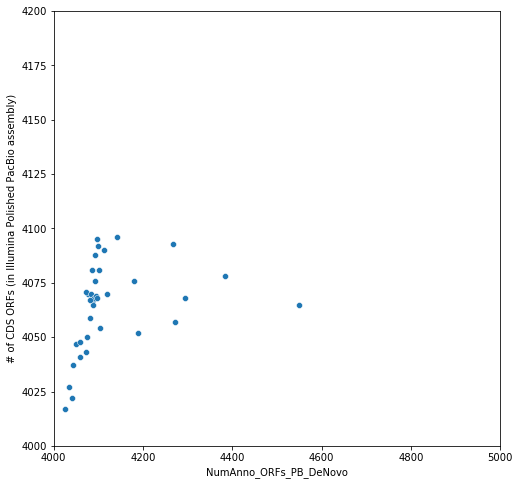

In [51]:
plt.figure( figsize = (8,8))
sns.scatterplot(x="NumAnno_ORFs_PB_DeNovo", y="NumAnno_ORFs_PB_PilonPolished",
                # hue = "Dataset_Tag",
                data = PMP_36CI_AnalysisSet_AssemblySummary)

plt.ylabel("# of CDS ORFs (in de novo PacBio assembly)")
plt.ylabel("# of CDS ORFs (in Illumina Polished PacBio assembly)")


plt.xlim(4000,5000)
plt.ylim(4000,4200)

plt.show()

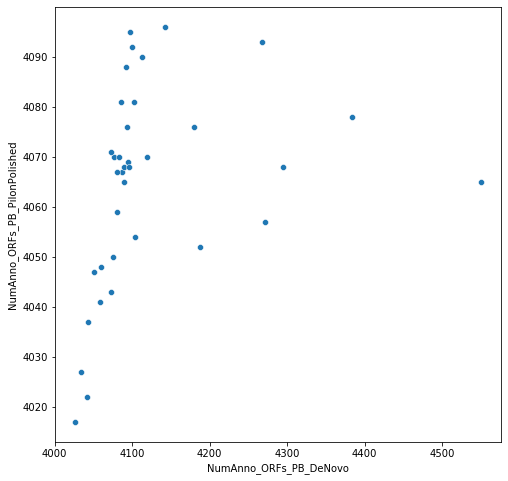

In [52]:
plt.figure( figsize = (8,8))
sns.scatterplot(x="NumAnno_ORFs_PB_DeNovo", y="NumAnno_ORFs_PB_PilonPolished",
                # hue = "Dataset_Tag",
                data = PMP_36CI_AnalysisSet_AssemblySummary)

#plt.xlim(4000,5000)
#plt.ylim(4000,5000)

plt.show()

<Figure size 576x576 with 0 Axes>

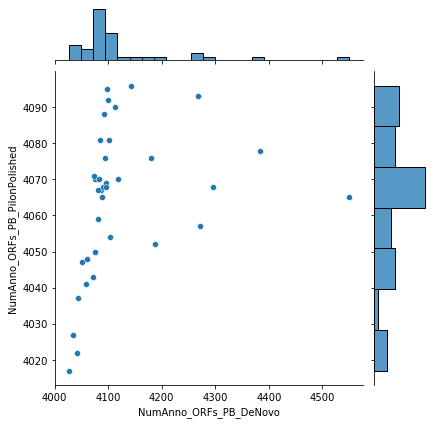

In [53]:
plt.figure( figsize = (8,8))
sns.jointplot(x="NumAnno_ORFs_PB_DeNovo", y="NumAnno_ORFs_PB_PilonPolished",
                # hue = "Dataset_Tag",
                data = PMP_36CI_AnalysisSet_AssemblySummary)

#plt.xlim(4000,5000)
#plt.ylim(4000,5000)

plt.show()

In [54]:
PMP_36CI_AnalysisSet_AssemblySummary.head(40)

,SampleID,numContigs_Complete,circContig_Length,circContig_Cov,PacBio_Subread_Median_Length,LineageCall_Illumina,LineageCall_PacBio,F2_Illumina,F2_PacBio,ANI_I3,ANI_I3_PP,IlluminaWGSToH37rv_AvrgCov,PacBio_Subreads_H37Rv_AvrgCov,NumAnno_ORFs_PB_PilonPolished,NumAnno_ORFs_PB_DeNovo,GCcontent_PB_PP_GBK,NumChanges_PilonPolished,NumSNPs_PilonPolished,NumTotalInsertions_PilonPolished,Num1bpInsertion_PilonPolished,Num2bpInsertion_PilonPolished,NumTotalDeletions_PilonPolished,Num1bpDeletion_PilonPolished,PrimaryLineage_PB,PrimaryLineage_Ill,Dataset_Tag,NumINDELs_All_PilonPolished,NumINDELs_1bp_PilonPolished
14,N0072,1,4421406,358,2413.0,"lineage1,lineage1.1,lineage1.1.2","lineage1,lineage1.1,lineage1.1.2",0.021909,0.263559,99.8849,99.8852,112,348,4047,4051,65.610969,11,0,4,3,1,7,7,lineage1,lineage1,ChinerOms_2019,11,10
15,N0153,1,4389210,372,2027.0,"lineage1,lineage1.1,lineage1.1.1,lineage1.1.1.1","lineage1,lineage1.1,lineage1.1.1,lineage1.1.1.1",0.023551,0.272487,99.8687,99.8692,98,370,4037,4043,65.612081,53,19,2,1,1,32,32,lineage1,lineage1,ChinerOms_2019,34,33
17,N0155,1,4415285,335,2167.0,"lineage2,lineage2.2,lineage2.2.1","lineage2,lineage2.2,lineage2.2.1",0.005962,0.253724,99.8969,99.8974,61,326,4070,4076,65.611330,36,15,5,5,0,16,16,lineage2,lineage2,ChinerOms_2019,21,21
11,M0003941_3,1,4420723,206,5023.5,"lineage2,lineage2.2,lineage2.2.1","lineage2,lineage2.2,lineage2.2.1",0.011555,0.334658,99.8797,99.8952,273,189,4093,4268,65.609616,453,0,449,448,1,4,4,lineage2,lineage2,Farhat_Peru_2019,453,452
27,DNA075,1,4410963,753,7087.0,"lineage2,lineage2.2,lineage2.2.1","lineage2,lineage2.2,lineage2.2.1",0.009901,0.270275,99.8885,99.8895,46,715,4067,4087,65.614151,54,3,5,5,0,46,46,lineage2,lineage2,TB_Portals_15CI_R1,51,51
28,DNA091,1,4409629,807,7041.0,"lineage2,lineage2.2,lineage2.2.1","lineage2,lineage2.2,lineage2.2.1",0.008816,0.269834,99.8936,99.8934,74,779,4059,4081,65.608685,48,0,4,3,1,44,44,lineage2,lineage2,TB_Portals_15CI_R1,48,47
26,DNA028,1,4418534,437,5819.0,"lineage2,lineage2.2,lineage2.2.1","lineage2,lineage2.2,lineage2.2.1",0.012282,0.252604,99.8934,99.8946,48,419,4076,4093,65.608486,50,3,5,5,0,42,42,lineage2,lineage2,TB_Portals_15CI_R1,47,47
16,N0145,1,4416863,344,2042.0,"lineage2,lineage2.2,lineage2.2.1,lineage2.2.1.1","lineage2,lineage2.2,lineage2.2.1,lineage2.2.1.1",0.008973,0.262688,99.8914,99.8941,89,344,4071,4073,65.604423,20,0,2,2,0,18,18,lineage2,lineage2,ChinerOms_2019,20,20
20,N0054,1,4433942,225,2798.0,lineage3,lineage3,0.010867,0.243561,99.9051,99.9051,80,220,4095,4097,65.610456,8,0,0,0,0,8,7,lineage3,lineage3,ChinerOms_2019,8,7
19,N1274,1,4439099,366,2058.0,lineage3,lineage3,0.014975,0.254314,99.9041,99.9035,92,359,4092,4100,65.621746,17,2,1,0,0,14,13,lineage3,lineage3,ChinerOms_2019,15,13


In [55]:
PMP_36CI_AnalysisSet_AssemblySummary.shape

(36, 28)

## Plotting the number of correction types from Pilon Polishing

In [56]:
PMP_36CI_Polish_DF = PMP_36CI_AnalysisSet_AssemblySummary[ ["SampleID", "NumSNPs_PilonPolished", "NumTotalInsertions_PilonPolished", "NumTotalDeletions_PilonPolished",]  ]

PMP_36CI_Polish_DF.columns = ["SampleID", "SNVs_Corrected", "Num_Insertions_AddedByPilon", "Num_Deletions_AddedByPilon"]

PMP_36CI_Polish_DF_Relabeled = PMP_36CI_Polish_DF.copy()
PMP_36CI_Polish_DF_Relabeled.columns = ["SampleID", "# of Substitutions By Pilon", "# Bases Inserted By Pilon (Erroneous Deletions)", "# Bases Deleted By Pilon (Erroneous Insertion)"]



In [57]:
PMP_36CI_Polish_DF_Relabeled.head(1)

,SampleID,# of Substitutions By Pilon,# Bases Inserted By Pilon (Erroneous Deletions),# Bases Deleted By Pilon (Erroneous Insertion)
14,N0072,0,4,7


In [58]:
PMP_36CI_Polish_DF.head(50)

,SampleID,SNVs_Corrected,Num_Insertions_AddedByPilon,Num_Deletions_AddedByPilon
14,N0072,0,4,7
15,N0153,19,2,32
17,N0155,15,5,16
11,M0003941_3,0,449,4
27,DNA075,3,5,46
28,DNA091,0,4,44
26,DNA028,3,5,42
16,N0145,0,2,18
20,N0054,0,0,8
19,N1274,2,1,14


In [59]:
PMP_36CI_Polish_DF.median()

SNVs_Corrected                  0.0
Num_Insertions_AddedByPilon     5.0
Num_Deletions_AddedByPilon     14.5
dtype: float64

In [60]:
PMP_36CI_Polish_DF.quantile(0.25)

SNVs_Corrected                 0.0
Num_Insertions_AddedByPilon    2.0
Num_Deletions_AddedByPilon     4.0
Name: 0.25, dtype: float64

In [61]:
PMP_36CI_Polish_DF.quantile(0.75, interpolation="nearest")

SNVs_Corrected                  2
Num_Insertions_AddedByPilon    88
Num_Deletions_AddedByPilon     37
Name: 0.75, dtype: int64

In [62]:
PMP_36CI_Polish_DF.quantile(0.75, interpolation="higher")

SNVs_Corrected                  2
Num_Insertions_AddedByPilon    90
Num_Deletions_AddedByPilon     37
Name: 0.75, dtype: int64

In [63]:
PMP_36CI_Polish_DF["SNVs_Corrected"].sum()

72

In [64]:
PMP_36CI_Polish_DF_CountsPerCorrectionType = PMP_36CI_Polish_DF_Relabeled.melt( id_vars= ["SampleID"],
                                                         value_name = 'Frequency',
                                                         var_name = 'CompType' )

In [65]:
PMP_36CI_Polish_DF_CountsPerCorrectionType.shape

(108, 3)

In [66]:
PMP_36CI_Polish_DF_CountsPerCorrectionType.head()

,SampleID,CompType,Frequency
0,N0072,# of Substitutions By Pilon,0
1,N0153,# of Substitutions By Pilon,19
2,N0155,# of Substitutions By Pilon,15
3,M0003941_3,# of Substitutions By Pilon,0
4,DNA075,# of Substitutions By Pilon,3


## What proportion of errors corrected by Pilon are erroneous deletions (Insertions by Pilon)

In [67]:
PMP_36CI_Polish_DF_CountsPerCorrectionType.groupby("CompType").sum() 

,Frequency
CompType,
# Bases Deleted By Pilon (Erroneous Insertion),739
# Bases Inserted By Pilon (Erroneous Deletions),4242
# of Substitutions By Pilon,72


In [68]:
PMP_36CI_Polish_DF_CountsPerCorrectionType.groupby("CompType").sum().sum()

Frequency    5053
dtype: int64

In [69]:
4332 / 5131

0.8442798674722276

In [70]:
(731 + 4332 )/ 5131

0.9867472227635938

In [71]:
PMP_36CI_Polish_DF_CountsPerCorrectionType.groupby("CompType").sum() / 5381

,Frequency
CompType,
# Bases Deleted By Pilon (Erroneous Insertion),0.137335
# Bases Inserted By Pilon (Erroneous Deletions),0.788329
# of Substitutions By Pilon,0.013380


In [72]:
PMP_36CI_Polish_DF_CountsPerCorrectionType.groupby("CompType").sum() / PMP_36CI_Polish_DF_CountsPerCorrectionType.groupby("CompType").sum().sum()

,Frequency
CompType,
# Bases Deleted By Pilon (Erroneous Insertion),0.146250
# Bases Inserted By Pilon (Erroneous Deletions),0.839501
# of Substitutions By Pilon,0.014249


In [73]:
PMP_36CI_Polish_DF_CountsPerCorrectionType["CompType"].value_counts()

# Bases Deleted By Pilon (Erroneous Insertion)     36
# Bases Inserted By Pilon (Erroneous Deletions)    36
# of Substitutions By Pilon                        36
Name: CompType, dtype: int64

### What is the median # of corrections of each type (SNV, INS, & DEL)?

In [74]:
PMP_36CI_Polish_DF_CountsPerCorrectionType.describe()

,Frequency
count,108.000000
mean,46.787037
std,145.193654
min,0.000000
25%,1.000000
50%,4.000000
75%,25.250000
max,1031.000000


In [75]:
PMP_36CI_Polish_DF_CountsPerCorrectionType.head()

,SampleID,CompType,Frequency
0,N0072,# of Substitutions By Pilon,0
1,N0153,# of Substitutions By Pilon,19
2,N0155,# of Substitutions By Pilon,15
3,M0003941_3,# of Substitutions By Pilon,0
4,DNA075,# of Substitutions By Pilon,3


mkdir: cannot create directory ‘./PilonPolishing_CorrectionsPlots/’: File exists


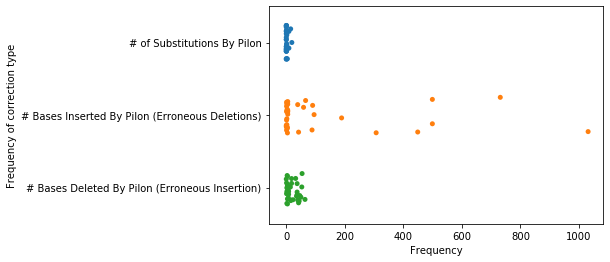

In [76]:
sns.stripplot(y = "CompType", x = "Frequency", data=PMP_36CI_Polish_DF_CountsPerCorrectionType, jitter=0.25)


plt.ylabel("Frequency of correction type")


!mkdir ./PilonPolishing_CorrectionsPlots/
Output_PNG_PATH = "./PilonPolishing_CorrectionsPlots/SupFig1A_PMP_36CI_PilonPolishing_FreqOfTypeOfCorrection_StripPlot.png"
Output_PDF_PATH = "./PilonPolishing_CorrectionsPlots/SupFig1A_PMP_36CI_PilonPolishing_FreqOfTypeOfCorrection_StripPlot.pdf"

plt.savefig(Output_PNG_PATH, bbox_inches='tight', dpi=125)
plt.savefig(Output_PDF_PATH, bbox_inches='tight', transparent=True)

plt.show()

mkdir: cannot create directory ‘./PilonPolishing_CorrectionsPlots/’: File exists


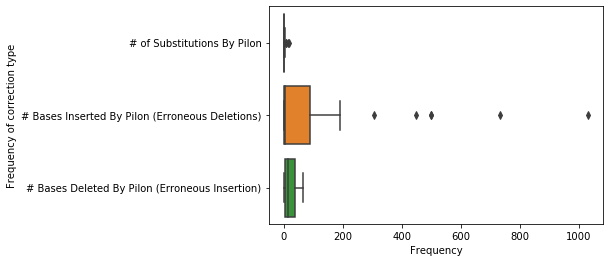

In [77]:
sns.boxplot(y = "CompType", x = "Frequency", data=PMP_36CI_Polish_DF_CountsPerCorrectionType)

plt.ylabel("Frequency of correction type")


!mkdir ./PilonPolishing_CorrectionsPlots/
Output_PNG_PATH = "./PilonPolishing_CorrectionsPlots/PMP_36CI_PilonPolishing_FreqOfTypeOfCorrection_BoxPlot.png"
Output_PDF_PATH = "./PilonPolishing_CorrectionsPlots/PMP_36CI_PilonPolishing_FreqOfTypeOfCorrection_BoxPlot.pdf"

plt.savefig(Output_PNG_PATH, bbox_inches='tight', dpi=125)
plt.savefig(Output_PDF_PATH, bbox_inches='tight', transparent=True)

plt.show()
plt.show()

## Plotting the distribution of lengths of corrections made by Pilon Polishing

#### https://github.com/broadinstitute/pilon/wiki/Output-File-Descriptions

In [78]:
i = 1

listOf_PilonChanges_DFs = []

for sampleID in tqdm( SampleIDs_36CI_SOI ) :
    
    Sample_Output_Dir = f"{PMP_SM_TB_Portals_R1_Illumina_WGS_201201_OutputDir}/{sampleID}"
    
    Sample_Pacbio_Dir = f"{Sample_Output_Dir}/pacbio"
    
    #PMPV4_24CI_R1_Lineage_DF["PrimaryLineage"] =  PMPV4_24CI_R1_Lineage_DF["Lineage"].str.split(",").str[0]
    
    sample_Pilon_OutputDir=f"{Sample_Output_Dir}/FlyeAssembly_I3_IlluminaPolishing/pilon_IllPE_Polishing_I3_Assembly_ChangeSNPsINDELsOnly/"
    
    #Ill_Pilon_VCF_PATH = sample_Pilon_OutputDir + f"/{sampleID}.IllPE.Q3Assembly.vcf"    

    
    Ill_Pilon_Changes_PATH = sample_Pilon_OutputDir + f"/{sampleID}.Flye.I3Assembly.PilonPolished.changes"
    
    #print(sampleID)
    try:
        Pilon_Changes_DF = pd.read_csv(Ill_Pilon_Changes_PATH, sep = " ", header = None)
        Pilon_Changes_DF.columns = ["Original_Coordinate", "UpdatedAssembly_Coordinate", "Original_Seq", "New_Seq"]
        Pilon_Changes_DF["SampleID"] = sampleID
        
        listOf_PilonChanges_DFs.append(Pilon_Changes_DF)
    except:
        continue
        
    #!wc -l $Ill_Pilon_Changes_PATH
    #!wc -l $Ill_Pilon_VCF_PATH   
    
    #break
    

100%|██████████| 36/36 [00:00<00:00, 136.21it/s]


In [79]:
Pilon_Changes_DF_All36CI = pd.concat(listOf_PilonChanges_DFs)
Pilon_Changes_DF_All36CI['Original_Seq'] = Pilon_Changes_DF_All36CI['Original_Seq'].str.replace('.','')
Pilon_Changes_DF_All36CI['New_Seq'] = Pilon_Changes_DF_All36CI['New_Seq'].str.replace('.','')
Pilon_Changes_DF_All36CI["Correction_Length"] = Pilon_Changes_DF_All36CI["New_Seq"].str.len() - Pilon_Changes_DF_All36CI["Original_Seq"].str.len()     
Pilon_Changes_DF_All36CI.shape

(5053, 6)

In [80]:
Pilon_Changes_DF_All36CI.head()

,Original_Coordinate,UpdatedAssembly_Coordinate,Original_Seq,New_Seq,SampleID,Correction_Length
0,N0072_contig_2:417486,N0072_contig_2_pilon:417486,C,,N0072,-1
1,N0072_contig_2:852062,N0072_contig_2_pilon:852061,G,,N0072,-1
2,N0072_contig_2:889307,N0072_contig_2_pilon:889305,G,,N0072,-1
3,N0072_contig_2:1069940,N0072_contig_2_pilon:1069937,G,,N0072,-1
4,N0072_contig_2:2016074,N0072_contig_2_pilon:2016070,T,,N0072,-1


In [81]:
Pilon_Changes_DF_All36CI.value_counts("SampleID")

SampleID
01_R1134       1034
02_R1708        735
M0017522_5      503
02_R1896        501
M0003941_3      453
02_R1179        309
02_R0894        190
M0010874_7      111
01_R1430         93
M0016737_0       92
M0016395_7       71
AZE_02_042       67
M0011368_9       63
N0091            57
DNA075           54
N0153            53
DNA044           53
DNA120           51
DNA028           50
DNA091           48
DNA020           44
RW-TB008         44
DNA086           41
N1272            41
DNA019_Rose      40
M0014888_3       39
DNA188           38
N0155            36
N1177            34
N0004            20
N0145            20
N1202            19
N1274            17
N1176            13
N0072            11
N0054             8
dtype: int64

In [82]:
# Export 

In [83]:
#!ls -1 $sample_Pilon_OutputDir

In [84]:
Pilon_Changes_DF_All36CI.head()

,Original_Coordinate,UpdatedAssembly_Coordinate,Original_Seq,New_Seq,SampleID,Correction_Length
0,N0072_contig_2:417486,N0072_contig_2_pilon:417486,C,,N0072,-1
1,N0072_contig_2:852062,N0072_contig_2_pilon:852061,G,,N0072,-1
2,N0072_contig_2:889307,N0072_contig_2_pilon:889305,G,,N0072,-1
3,N0072_contig_2:1069940,N0072_contig_2_pilon:1069937,G,,N0072,-1
4,N0072_contig_2:2016074,N0072_contig_2_pilon:2016070,T,,N0072,-1


In [85]:
Pilon_Changes_DF_All36CI[Pilon_Changes_DF_All36CI["Correction_Length"] == -1].shape

(731, 6)

In [86]:
Pilon_Changes_DF_All36CI[Pilon_Changes_DF_All36CI["Correction_Length"] == -1]["Original_Seq"].value_counts()

C    300
G    279
A     81
T     71
Name: Original_Seq, dtype: int64

In [87]:
Pilon_Changes_DF_All36CI[Pilon_Changes_DF_All36CI["Correction_Length"] == 1]["New_Seq"].value_counts()

C    2208
G    1970
A      16
T      12
Name: New_Seq, dtype: int64

In [88]:
Pilon_Changes_DF_All36CI.head()

,Original_Coordinate,UpdatedAssembly_Coordinate,Original_Seq,New_Seq,SampleID,Correction_Length
0,N0072_contig_2:417486,N0072_contig_2_pilon:417486,C,,N0072,-1
1,N0072_contig_2:852062,N0072_contig_2_pilon:852061,G,,N0072,-1
2,N0072_contig_2:889307,N0072_contig_2_pilon:889305,G,,N0072,-1
3,N0072_contig_2:1069940,N0072_contig_2_pilon:1069937,G,,N0072,-1
4,N0072_contig_2:2016074,N0072_contig_2_pilon:2016070,T,,N0072,-1


In [89]:
Pilon_Changes_DF_All36CI[ Pilon_Changes_DF_All36CI["Correction_Length"] <= -10]

,Original_Coordinate,UpdatedAssembly_Coordinate,Original_Seq,New_Seq,SampleID,Correction_Length
2,RW-TB008_contig_1:669588-669632,RW-TB008_contig_1_pilon:669590,CCGGTGCCGCCGGCACCGCCGGCACCACCGGTGCCGCCGGTGCCG,,RW-TB008,-45


In [90]:
Pilon_Changes_DF_All36CI[ Pilon_Changes_DF_All36CI["Correction_Length"] >= 10]

,Original_Coordinate,UpdatedAssembly_Coordinate,Original_Seq,New_Seq,SampleID,Correction_Length
13,N1274_contig_1:2365307,N1274_contig_1_pilon:2365287-2365300,,GGTCGAAACGGTAC,N1274,14
20,01_R1430_contig_1:1234416,01_R1430_contig_1_pilon:1234436-1234446,,GTGCCGCGATC,01_R1430,11
38,N0091_contig_1:2813423,N0091_contig_1_pilon:2813384-2813395,,CCCTGGACGTAA,N0091,12


In [91]:
Pilon_Changes_DF_All36CI.sort_values("Correction_Length", ascending=False).head(3)

,Original_Coordinate,UpdatedAssembly_Coordinate,Original_Seq,New_Seq,SampleID,Correction_Length
13,N1274_contig_1:2365307,N1274_contig_1_pilon:2365287-2365300,,GGTCGAAACGGTAC,N1274,14
38,N0091_contig_1:2813423,N0091_contig_1_pilon:2813384-2813395,,CCCTGGACGTAA,N0091,12
20,01_R1430_contig_1:1234416,01_R1430_contig_1_pilon:1234436-1234446,,GTGCCGCGATC,01_R1430,11


In [92]:
Pilon_Changes_DF_All36CI["Correction_Length"].value_counts()

 1     4206
-1      731
 0       72
 2       20
 3        6
-2        4
 5        3
-3        2
 7        1
 14       1
 6        1
 11       1
 9        1
-9        1
 12       1
 4        1
-45       1
Name: Correction_Length, dtype: int64

In [93]:
Pilon_Changes_DF_All36CI["Correction_Length"].value_counts(normalize=True)

 1     0.832377
-1     0.144667
 0     0.014249
 2     0.003958
 3     0.001187
-2     0.000792
 5     0.000594
-3     0.000396
 7     0.000198
 14    0.000198
 6     0.000198
 11    0.000198
 9     0.000198
-9     0.000198
 12    0.000198
 4     0.000198
-45    0.000198
Name: Correction_Length, dtype: float64

In [94]:
0.836897 + 0.141913

0.97881

In [95]:
0.838238 + 0.140908

0.9791460000000001

In [96]:
Pilon_Changes_DF_All36CI["Correction_Length"].describe()

count    5053.000000
mean        0.701168
std         1.038145
min       -45.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        14.000000
Name: Correction_Length, dtype: float64

mkdir: cannot create directory ‘./PilonPolishing_CorrectionsPlots/’: File exists


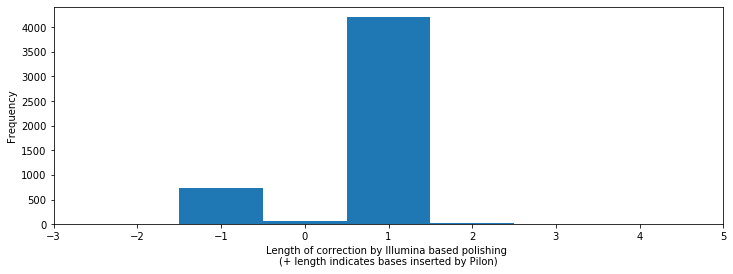

In [102]:

plt.figure( figsize = (12, 4))

binmids = np.arange(-45,15)
plt.hist(Pilon_Changes_DF_All36CI["Correction_Length"], bins = np.arange(-45.5,15.5))
plt.xticks(binmids[::1]) 

plt.xlim(-3, 5)

plt.xlabel("Length of correction by Illumina based polishing \n(+ length indicates bases inserted by Pilon)")
plt.ylabel("Frequency")

!mkdir ./PilonPolishing_CorrectionsPlots/
Output_PNG_PATH = "./PilonPolishing_CorrectionsPlots/SupFig1B_PMP_36CI_PilonPolishing_LengthOfCorrection_Histo.png"
Output_PDF_PATH = "./PilonPolishing_CorrectionsPlots/SupFig1B_PMP_36CI_PilonPolishing_LengthOfCorrection_Histo.pdf"

plt.savefig(Output_PNG_PATH, bbox_inches='tight', dpi=125)
plt.savefig(Output_PDF_PATH, bbox_inches='tight', transparent=True)

plt.show()

In [98]:
PMP_36CI_Polish_DF_CountsPerCorrectionType[ PMP_36CI_Polish_DF_CountsPerCorrectionType["SampleID"] == "N1176" ]

,SampleID,CompType,Frequency
31,N1176,# of Substitutions By Pilon,0
67,N1176,# Bases Inserted By Pilon (Erroneous Deletions),5
103,N1176,# Bases Deleted By Pilon (Erroneous Insertion),8


## Output Pilon Polishing Results - Supplemental/Additional File 

In [99]:
Repo_DataDir = "../../Data"

PilonPolishing_Changes_Dir = Repo_DataDir + "/210126_PilonPolishing_Results"

!mkdir $PilonPolishing_Changes_Dir

PMP_36CI_PilonPolishing_Changes_TSV = PilonPolishing_Changes_Dir + "/210126.PacBioAssembly.IlluminaPolishing.Pilon.AllChanges.36Isolates.tsv"

PMP_36CI_PilonPolishing_SummaryOfChangeTypes_TSV = PilonPolishing_Changes_Dir + "/210126.PacBioAssembly.IlluminaPolishing.Pilon.SummaryOfChangeTypes.tsv"


Pilon_Changes_DF_All36CI.to_csv(PMP_36CI_PilonPolishing_Changes_TSV, sep = "\t", index=False)

PMP_36CI_Polish_DF_Relabeled.to_csv(PMP_36CI_PilonPolishing_SummaryOfChangeTypes_TSV, sep = "\t", index=False)


mkdir: cannot create directory ‘../../Data/210126_PilonPolishing_Results’: File exists


In [100]:
!ls -lah $PMP_36CI_PilonPolishing_Changes_TSV

-rw-rw-r-- 1 mm774 farhat 358K Mar 30 14:54 ../../Data/210126_PilonPolishing_Results/210126.PacBioAssembly.IlluminaPolishing.Pilon.AllChanges.36Isolates.tsv


In [101]:
Pilon_Changes_DF_All36CI.head()

,Original_Coordinate,UpdatedAssembly_Coordinate,Original_Seq,New_Seq,SampleID,Correction_Length
0,N0072_contig_2:417486,N0072_contig_2_pilon:417486,C,,N0072,-1
1,N0072_contig_2:852062,N0072_contig_2_pilon:852061,G,,N0072,-1
2,N0072_contig_2:889307,N0072_contig_2_pilon:889305,G,,N0072,-1
3,N0072_contig_2:1069940,N0072_contig_2_pilon:1069937,G,,N0072,-1
4,N0072_contig_2:2016074,N0072_contig_2_pilon:2016070,T,,N0072,-1
